In [5]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
sns.set(style='white', palette='colorblind', color_codes=True, font_scale=1.5)

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBandits, Random

from setup_environment import *

context = torch.from_numpy(np.load('context_{}.npy'.format(blocks)))
offers = torch.from_numpy(np.load('offers_{}.npy'.format(blocks)))

In [2]:
a = 2*torch.stack([torch.eye(nf), torch.eye(nf)]).reshape(-1, 3)[arm_types] + 1
a = a.repeat(nsub, 1, 1, 1)

nd = 20
pars = {
    'nd': nd,
    'ns': 4,  # number of arm types
    'na': na,
    'nc': 6,  # number of contexts
    'nf': nf,
    'ni': 2,  # number of internal states
}

Bdd = zeros(nd, nd)

d = torch.arange(1., nd + 1.)
alpha = 1.
beta = .2
Bdd[0] = (-d * beta + (alpha - 1) * d.log()).softmax(-1)
Bdd[range(1, nd), range(nd-1)] = 1.

Bccd = zeros(nd, 6, 6)
Bccd[0] = (ones(6, 6) - eye(6))/5
Bccd[1:] = eye(6).repeat(nd-1, 1, 1)

tm_higher = {
    'context': Bccd,
    'duration': Bdd
}

ev_agent1 = AIBandits(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
ev_agent1.set_parameters(x = [a], depth=trials, epistemic=True)

pars = {
    'nd': nd,
    'ns': 4,  # number of arm types
    'na': na,
    'nc': 6,  # number of contexts
    'nf': nf,
    'ni': 1,  # internal states change preference over features, for now they match number of features
}

ev_agent2 = AIBandits(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
ev_agent2.set_parameters(x = [a], depth=trials, epistemic=True)

ev_agent3 = AIBandits(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
ev_agent3.set_parameters(x = [a], depth=trials, epistemic=False)

envs = []
agents = [ev_agent1, ev_agent2, ev_agent3]
for i in range(len(agents)):
    envs.append(bandits.MultiArmedBandit(priors, 
                                transitions, 
                                context,
                                offers,
                                arm_types,
                                nsub=nsub, 
                                blocks=blocks, 
                                trials=trials))

sim = Simulator(envs, agents, runs=nsub, blocks=blocks, trials=trials)
sim.simulate_experiment()

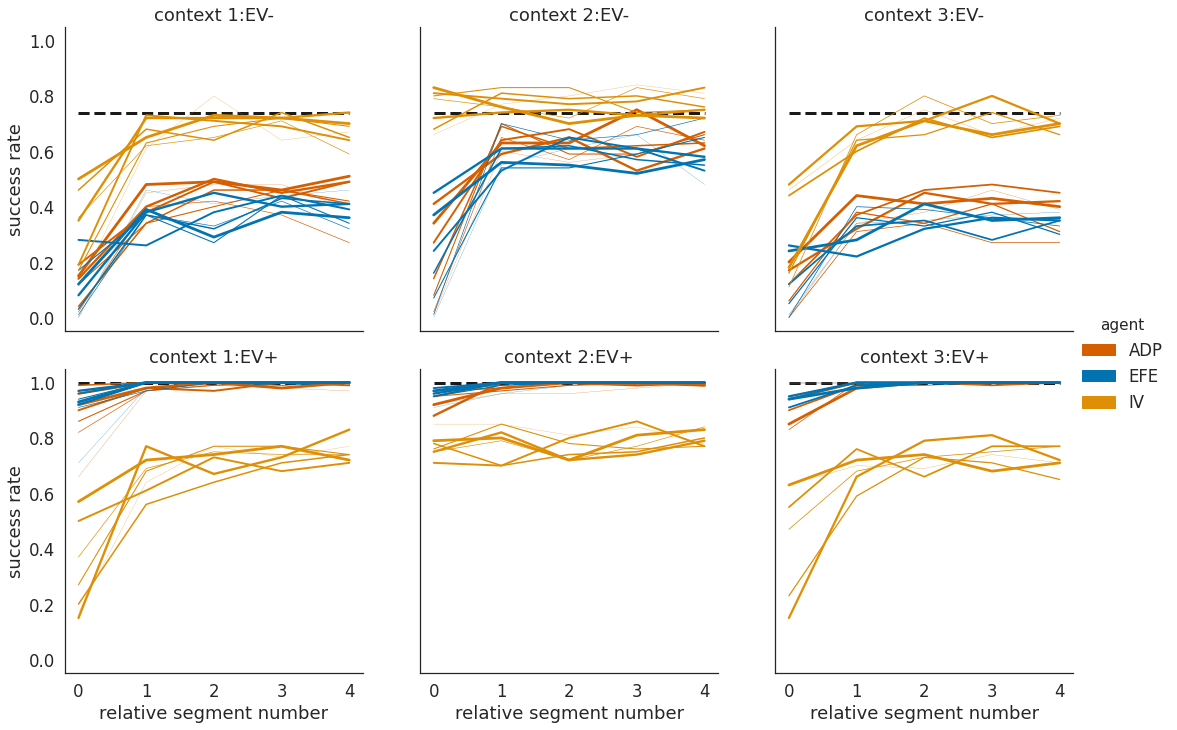

In [19]:
successes = []

out = []
for i in range(3):
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1], 
                                  out3[-1][-1]],
                                  -1))
    
successes = torch.stack(successes).float()

df = pd.DataFrame({'context': [1, 1, 2, 2, 3, 3] , 'variant': ['A', 'B', 'A', 'B', 'A', 'B']})
titles = ['context 1:EV-', 'context 2:EV-', 'context 3:EV-', 'context 1:EV+', 'context 2:EV+', 'context 3:EV+']


g = sns.FacetGrid(df, col='context', row='variant', height=5)
for i in range(2):
    g.axes[i, 0].set_ylabel('success rate')
for j in range(3):
    g.axes[-1, j].set_xlabel('relative segment number')

axes = g.axes.flatten()
colors = sns.color_palette(palette='colorblind')[3:4] + sns.color_palette(palette='colorblind')[:2]
labels = ['ADP', 'EFE', 'IV']
for c, vc in enumerate([0, 2, 4, 1, 3, 5]):
    loc = offers[:, 0, 0] == vc
    sccs = successes[loc].reshape(-1, 5, nsub, 3).mean(-2)
    K = sccs.shape[0]
    lws = np.arange(3/(2*K), 3, 3/K)
    axes[c].set_title(titles[c])
    if c < 3:
        axes[c].hlines(0.73728, 0, 4, 'k', linestyle='--', lw=3)
    else:
        axes[c].hlines(1., 0, 4, 'k', linestyle='--', lw=3)
        
    for i in range(3):
        for j, lw in enumerate(lws):
            if c == 0 and j == len(lws) - 1:
                label = labels[i]
            else:
                label = None
                
            axes[c].plot(sccs[j, ..., i].numpy().T, c=colors[i], lw=lw);
            
import matplotlib as mpl

legend_data = {}
for i in range(3):
    legend_data[labels[i]] = mpl.patches.Patch(color=colors[i], linewidth=1)
g.add_legend(legend_data, title='agent', label_order=labels)

g.fig.savefig('Fig5.png', bbox_inches='tight', dpi=300)

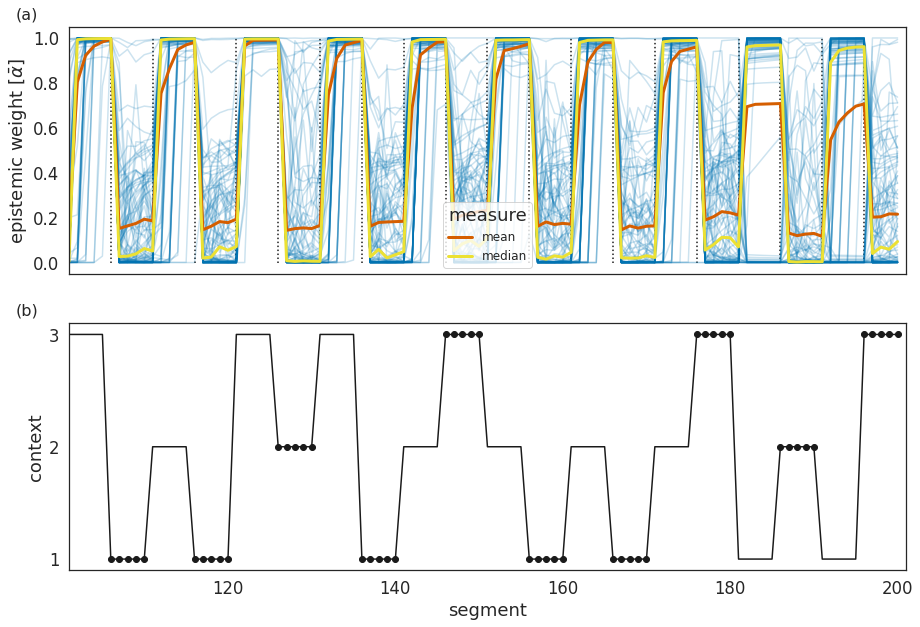

In [14]:
N = nsub//3
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
blks = torch.arange(1, blocks + 1).numpy()

internals = torch.stack(ev_agent1.priors['internals'])
axes[0].plot(blks, internals[..., -1].numpy(), 'b', alpha = .2);
axes[0].plot(blks, internals[..., -1].mean(-1).numpy(), 'r', lw = 3, label='mean');
axes[0].plot(blks, internals[..., -1].median(-1)[0].numpy(), 'y', lw = 3, label='median');
axes[0].vlines(np.arange(6, blocks, 5), 0, 1, 'k', linestyle=':')
axes[0].legend(loc=8, title='measure', fontsize=12)
axes[0].set_ylabel(r'epistemic weight $\left[\bar{\alpha}\right]$')

offs = offers[:,0,0]
offs = ((offs == 0) + (offs == 4) + (offs == 2)).float()
locs = offs == 1

axes[1].plot(blks, context + 1, 'k');
axes[1].plot(blks[locs], context[locs] + 1, 'ko')
axes[1].set_ylabel('context')
axes[1].set_yticks([1, 2, 3])
axes[1].set_xlabel('segment')

plt.xlim([101, blocks + 1]);


axes[0].text(-.05, 1.05, r'(a)', fontsize=16, horizontalalignment='center', 
             verticalalignment='center', transform=axes[0].transAxes)
axes[1].text(-.05, 1.05, r'(b)', fontsize=16, horizontalalignment='center', 
             verticalalignment='center', transform=axes[1].transAxes)

fig.savefig('Fig6.png', bbox_inches='tight', transparent=True, dpi=300)

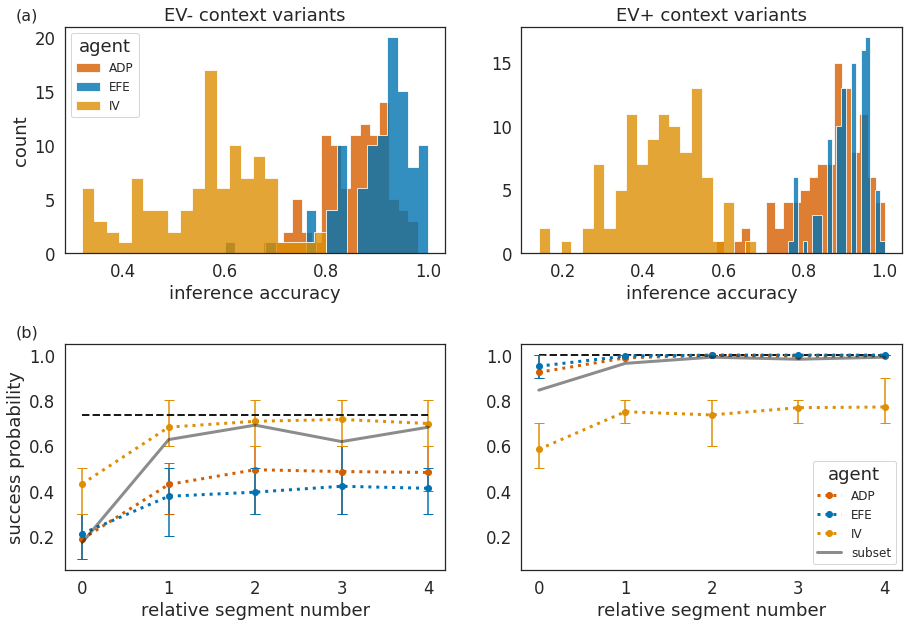

In [18]:
# EV agent is more accurate in estimating current context

cut = 100

offs = offers[:, 0, 0]
locsA = torch.tensor([1 if offs[j] in [0, 2, 4] else 0 for j in range(len(offs))]).bool()
locsA[:-cut] = False

locsB = torch.tensor([1 if offs[j] in [1, 3, 5] else 0 for j in range(len(offs))]).bool()
locsB[:-cut] = False

corr0 = ev_agent1.beliefs['context'].argmax(-1) == offers[:, 0]
corr1 = ev_agent2.beliefs['context'].argmax(-1) == offers[:, 0]
corr2 = ev_agent3.beliefs['context'].argmax(-1) == offers[:, 0]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4)

############ plot inference accuracy ###############
####################################################
labels = ['ADP', 'EFE', 'IV']
corr = [corr0, corr1, corr2]
for i in range(3):
    axes[0, 0].hist(corr[i][locsA].float().mean(0), bins=20, color=colors[i], alpha=.8, label=labels[i], histtype='stepfilled')
    axes[0, 1].hist(corr[i][locsB].float().mean(0), bins=20, color=colors[i], alpha=.8, histtype='stepfilled');

axes[0, 0].set_ylabel('count')
axes[0, 0].set_xlabel('inference accuracy')
axes[0, 1].set_xlabel('inference accuracy')

axes[0, 0].set_title('EV- context variants')
axes[0, 1].set_title('EV+ context variants')

axes[0, 0].legend(loc=2, title='agent', fontsize=12);

######### plot success probability #############
################################################
internals = torch.stack(ev_agent1.priors['internals'])

small1 = (internals[101::10, :, -1] < .5).sum(-2) > 5
small2 = (internals[106::10, :, -1] > .5).sum(-2) > 5
cut = 20
res = successes.reshape(-1, 5, nsub, 3)

offs = offers[:, 0, 0].reshape(-1, 5)[:, 0]
locsA = torch.tensor([1 if offs[j] in [0, 2, 4] else 0 for j in range(len(offs))]).bool()
locsA[:-cut] = False

locsB = torch.tensor([1 if offs[j] in [1, 3, 5] else 0 for j in range(len(offs))]).bool()
locsB[:-cut] = False

shape = ['o', 'd', 'x']
label = ['ADP', 'EFE', 'IV']
x = [0, 1, 2, 3, 4]
for i in range(3):
    mean = res[locsA, ..., i].mean(0).mean(1).numpy()
    perc = np.percentile(res[locsA, ..., i].mean(0).numpy(), [25, 50, 75], 1)
    yerr = [perc[1] - perc[0], perc[2] - perc[1]]
    axes[1, 0].errorbar(x, perc[1], yerr=yerr, c=colors[i], linestyle='', capsize=5);
    axes[1, 0].plot(x, mean, 'o:', lw=3, c=colors[i], label=label[i])

    mean = res[locsB, ..., i].mean(0).mean(1).numpy()
    perc = np.percentile(res[locsB, ..., i].mean(0).numpy(), [25, 50, 75], 1)
    yerr = [perc[1] - perc[0], perc[2] - perc[1]]
    axes[1, 1].errorbar(x, perc[1], yerr=yerr, c=colors[i], linestyle='', capsize=5);
    axes[1, 1].plot(x, mean, 'o:', lw=3, c=colors[i], label=label[i])
    
axes[1, 0].plot([0, 1, 2, 3, 4], res[locsA][:, :, small1, 0].mean(0).mean(1), lw=3, c='k', alpha=.5);
axes[1, 1].plot([0, 1, 2, 3, 4], res[locsB][:, :, small1, 0].mean(0).mean(1), lw=3, c='k', alpha=.5, label='subset');

axes[1, 0].hlines(0.73728, 0, 4, 'k', linestyle='--', lw=2)
axes[1, 1].hlines(1., 0, 4, 'k', linestyle='--', lw=2)

axes[1, 0].set_ylim([0.05, 1.05])
axes[1, 1].set_ylim([0.05, 1.05])

axes[1, 1].legend(loc=4, title='agent', fontsize=12);
axes[1, 0].set_ylabel('success probability');
axes[1, 0].set_xlabel('relative segment number');
axes[1, 1].set_xlabel('relative segment number');

axes[0, 0].text(-.1, 1.05, r'(a)', fontsize=16, horizontalalignment='center', 
                verticalalignment='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-.1, 1.05, r'(b)', fontsize=16, horizontalalignment='center', 
                verticalalignment='center', transform=axes[1, 0].transAxes)

plt.xticks([0, 1, 2, 3, 4]);
####################################################################################################

fig.savefig('Fig7.png', bbox_inches='tight', transparent=True, dpi=300)

In [11]:
import scipy.stats as stats

m1 = res[locsA].mean(0)
m2 = res[locsB].mean(0)

for i in range(5):
    print(stats.wilcoxon((m1[i, :, 0] - m1[i, :, 1]).reshape(-1).numpy()))
    print(stats.wilcoxon((m1[i, :, 0] - m1[i, :, 2]).reshape(-1).numpy()))
    print(stats.wilcoxon((m1[i, :, 1] - m1[i, :, 2]).reshape(-1).numpy()))
    
    print(stats.wilcoxon((m2[i, :, 0] - m2[i, :, 2]).reshape(-1).numpy()))
    print(stats.wilcoxon((m2[i, :, 1] - m2[i, :, 2]).reshape(-1).numpy()))

WilcoxonResult(statistic=1203.5, pvalue=0.23976305530899034)
WilcoxonResult(statistic=39.0, pvalue=2.4624191226160817e-15)
WilcoxonResult(statistic=143.0, pvalue=2.4146794351523863e-14)
WilcoxonResult(statistic=0.0, pvalue=1.97003500583921e-17)
WilcoxonResult(statistic=6.5, pvalue=7.278766811156222e-18)
WilcoxonResult(statistic=1632.0, pvalue=0.1287779488175068)
WilcoxonResult(statistic=343.5, pvalue=2.5235369432622543e-12)
WilcoxonResult(statistic=96.0, pvalue=2.4259185934548822e-15)
WilcoxonResult(statistic=31.0, pvalue=2.0012017572292242e-16)
WilcoxonResult(statistic=0.0, pvalue=2.1498439340301184e-17)
WilcoxonResult(statistic=953.5, pvalue=7.646907137550006e-05)
WilcoxonResult(statistic=421.0, pvalue=4.712936541184299e-12)
WilcoxonResult(statistic=29.5, pvalue=1.3218878568278244e-16)
WilcoxonResult(statistic=0.0, pvalue=4.648064439415739e-17)
WilcoxonResult(statistic=0.0, pvalue=3.202945003270372e-17)
WilcoxonResult(statistic=1471.0, pvalue=0.02016577408429622)
WilcoxonResult(stati